# Imports

In [ ]:
import zipfile, os
import os
from torch.utils.data import Dataset
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid

# Utils

In [ ]:
def parse_plate_from_filename(filename, provinces, alphabets, ads):
    name = os.path.splitext(os.path.basename(filename))[0]
    parts = name.split('-')
    indices = list(map(int, parts[4].split('_')))
    plate = provinces[indices[0]] + alphabets[indices[1]] + ''.join([ads[i] for i in indices[2:]])
    return plate

In [ ]:
# Funzione per unire batch con label di lunghezza variabile
def collate_fn(batch):
    images, labels = zip(*batch)
    image_batch = torch.stack(images)
    label_lens = torch.tensor([len(label) for label in labels])
    labels_concat = torch.cat(labels)
    return image_batch, labels_concat, label_lens

In [ ]:
def greedy_decode(output, idx_to_char):
    output = output.permute(1, 0, 2)  # [B, T, C]
    decoded = []

    for probs in output:
        pred = torch.argmax(probs, dim=1).tolist()  # [T]
        prev = -1
        seq = []
        for p in pred:
            if p != prev and p != 0:
                seq.append(idx_to_char[p])
            prev = p
        decoded.append("".join(seq))

    return decoded


def compute_accuracy(preds, targets):
  correct_chars = total_chars = correct_plates = 0
  for p, t in zip(preds, targets):
      total_chars += max(len(p), len(t))
      correct_chars += sum(a == b for a, b in zip(p, t))
      if p == t:
          correct_plates += 1
  cer = correct_chars / total_chars
  plate_acc = correct_plates / len(targets)
  return cer, plate_acc

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
def denormalize(tensor, mean=[0.5]*3, std=[0.5]*3):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean

def show_misclassified_images(dataset, preds, targets, num_images=6):
    errors = [(i, p, t) for i, (p, t) in enumerate(zip(preds, targets)) if p != t]
    selected = random.sample(errors, min(num_images, len(errors)))

    fig, axes = plt.subplots(2, 3, figsize=(15, 6))
    axes = axes.flatten()

    for ax, (idx, pred, true) in zip(axes, selected):
        img, _ = dataset[idx]  # (C, H, W)
        img = denormalize(img).clamp(0, 1)
        img = TF.to_pil_image(img)

        ax.imshow(img)
        ax.set_title(f"GT: {true}\nPred: {pred}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def evaluate_on_loader(model, dataloader, idx_to_char, device):
    model.eval()
    total = 0
    correct = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            outputs = model(images)  # [T, B, C]
            preds = greedy_decode(outputs, idx_to_char)

            for pred, true in zip(preds, labels):
                all_preds.append(pred)
                all_targets.append(true)
                total += 1
                if pred == true:
                    correct += 1

    acc = correct / total * 100
    return all_preds, all_targets

# Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = "/content/drive/MyDrive/Dataset_CV/RECOGNITION/CCPD2020_recogniton.zip"

extract_dir = "/content/green"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
# Vocabulary
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫",
             "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N',
             'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P',
       'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3',
       '4', '5', '6', '7', '8', '9', 'O']

vocab = sorted(set(provinces + alphabets + ads))
idx_to_char = ['-'] + sorted(set(provinces + alphabets + ads))
char_to_idx = {char: idx for idx, char in enumerate(idx_to_char)}  # ora 0 = blank
num_classes = len(idx_to_char)

In [ ]:
class CCPDCRNNDatasetFromName(Dataset):
    def __init__(self, image_dir, transform, char_to_idx):
        self.image_dir = image_dir
        self.transform = transform
        self.char_to_idx = char_to_idx
        self.image_paths = [os.path.join(image_dir, f)
                            for f in sorted(os.listdir(image_dir))
                            if f.lower().endswith(".jpg")]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        label_str = parse_plate_from_filename(img_path, provinces, alphabets, ads)
        label = torch.tensor([self.char_to_idx[c] for c in label_str], dtype=torch.long)

        return image, label

In [ ]:
class CCPDTestDataset(Dataset):
    def __init__(self, image_dir, transform, provinces, alphabets, ads):
        self.image_paths = sorted([
            os.path.join(image_dir, f) for f in os.listdir(image_dir)
            if f.lower().endswith(".jpg")
        ])
        self.transform = transform
        self.provinces = provinces
        self.alphabets = alphabets
        self.ads = ads

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        image = Image.open(path).convert("RGB")
        label_str = parse_plate_from_filename(path, self.provinces, self.alphabets, self.ads)
        if self.transform:
            image = self.transform(image)
        return image, label_str

In [ ]:
#Tranformations for data augmentation
transform = transforms.Compose([
    transforms.Resize((48, 144)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


train_transforms = transforms.Compose([
    transforms.Resize((48, 144)),

    transforms.RandomApply([
        transforms.RandomAffine(
            degrees=10,
            shear=10,
            translate=(0.03, 0.03),
            scale=(0.9, 1.1)
        )
    ], p=0.6),

    transforms.RandomApply([
        transforms.RandomPerspective(distortion_scale=0.4)
    ], p=0.5),

    transforms.RandomApply([
        transforms.ColorJitter(
            brightness=0.3,
            contrast=0.3,
            saturation=0.3,
            hue=0.1
        )
    ], p=0.7),

    transforms.RandomGrayscale(p=0.1),

    transforms.ToTensor(),

    transforms.RandomApply([
        transforms.Lambda(lambda x: torch.clamp(x + 0.03 * torch.randn_like(x), 0., 1.))
    ], p=0.3),

    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.2, 0.6))
    ], p=0.5),

    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


In [ ]:
# Dataset
train_dataset = CCPDCRNNDatasetFromName(
    image_dir="/content/green/train",
    transform=train_transforms,
    char_to_idx=char_to_idx
)

val_dataset = CCPDCRNNDatasetFromName(
    image_dir="/content/green/val",
    transform=transform,
    char_to_idx=char_to_idx
)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)


test_dataset = CCPDTestDataset("/content/green/test", transform, provinces, alphabets, ads)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


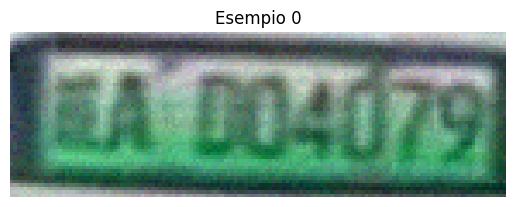

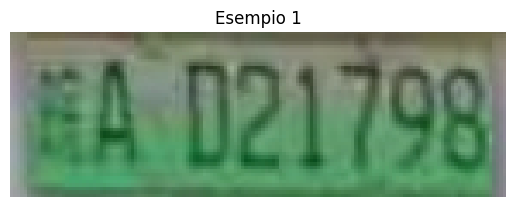

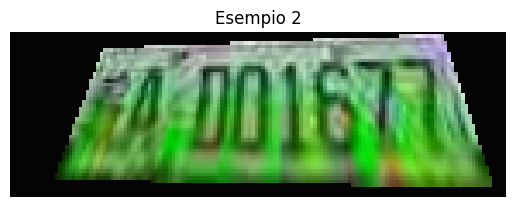

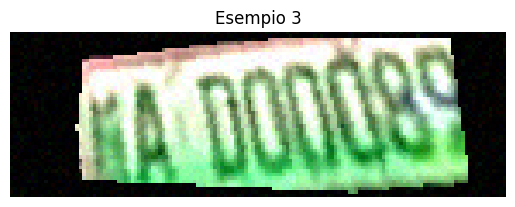

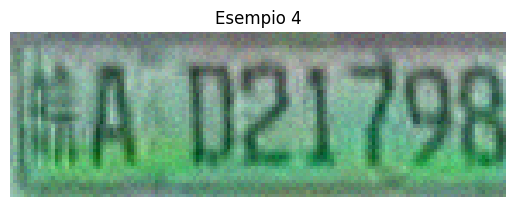

In [ ]:
for i in range(5):
    img, _ = train_dataset[i]
    img = img.permute(1, 2, 0) * 0.5 + 0.5  # denormalizza
    plt.imshow(img.numpy())
    plt.title(f"Esempio {i}")
    plt.axis('off')
    plt.show()

# Network (CRNN)

In [ ]:
class CRNN(nn.Module):
    def __init__(self, img_height, num_classes):
        super(CRNN, self).__init__()

        # INPUT: [B, 3, 48, 144]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),  # RGB input
            nn.ReLU(),
            nn.MaxPool2d(2, 2),              # [B, 64, 24, 72]

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),              # [B, 128, 12, 36]

            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), (2, 1), padding=(0, 1)),  # [B, 256, 6, 37]

            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), (2, 1), padding=(0, 1))   # [B, 512, 3, 38]
        )

        self.rnn = nn.GRU(input_size=512 * 3, hidden_size=128,
                  num_layers=1, bidirectional=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(128 * 2, num_classes)


    def forward(self, x):
        conv = self.cnn(x)            # [B, 512, 3, 38]
        b, c, h, w = conv.size()
        conv = conv.permute(3, 0, 1, 2)   # [T=38, B, C, H=3]
        conv = conv.reshape(w, b, c * h) # [T=38, B, 512*3]

        rnn_out, _ = self.rnn(conv)      # [T, B, 512]
        rnn_out = self.dropout(rnn_out)
        output = self.fc(rnn_out)        # [T, B, num_classes]
        return F.log_softmax(output, dim=2)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = CRNN(img_height=48, num_classes=num_classes).to(device)
criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=5)


cuda


# Train (Fine-tuning with checkpoints)

In [ ]:
def train_finetune(model, train_loader, val_loader, epochs, device, optimizer, criterion, scheduler=None, seed=42):
    set_seed(seed)

    checkpoint_dir = "/content/drive/MyDrive/Computer_vision/crnn_finetune_weights_ccpd2020"
    os.makedirs(checkpoint_dir, exist_ok=True)
    last_ckpt_path = os.path.join(checkpoint_dir, "last_crnn_finetune.pth")
    best_ckpt_path = os.path.join(checkpoint_dir, "best_crnn_finetune.pth")

    best_val_loss = float('inf')
    start_epoch = 0


    for epoch in range(start_epoch, epochs):
        model.train()
        total_loss = 0
        pbar = tqdm(train_loader, desc=f"[FT] Epoch {epoch+1}/{epochs}")

        for images, labels, label_lengths in pbar:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)  # [T, B, C]
            T, B = outputs.size(0), outputs.size(1)
            input_lengths = torch.full(size=(B,), fill_value=T, dtype=torch.long, device=device)

            loss = criterion(outputs, labels, input_lengths, label_lengths)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix(train_loss=total_loss / (pbar.n + 1),
                             lr=optimizer.param_groups[0]['lr'])

        val_loss = evaluate_finetune(model, val_loader, criterion, device)
        print(f"\n[FT] Epoch {epoch+1} - Val Loss: {val_loss:.4f}")

        #Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'best_val_loss': best_val_loss
        }, last_ckpt_path)

        #Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_ckpt_path)
            print("Best model saved!")


def evaluate_finetune(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for images, labels, label_lengths in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)  # [T, B, C]
            T, B = outputs.size(0), outputs.size(1)
            input_lengths = torch.full(size=(B,), fill_value=T, dtype=torch.long, device=device)

            loss = criterion(outputs, labels, input_lengths, label_lengths)
            total_loss += loss.item()

            preds = greedy_decode(outputs, idx_to_char)
            targets = []
            start = 0
            for length in label_lengths:
                label_seq = labels[start:start+length]
                text = ''.join([idx_to_char[i.item()] for i in label_seq])
                targets.append(text)
                start += length

            print("Pred:", preds[:3])
            print("True:", targets[:3])
            break

    return total_loss / len(val_loader)


criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-5)


scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=1, verbose=True
)


#load the weights
state_dict = torch.load("/content/drive/MyDrive/Computer_vision/crnn_weights_ccpd2019/best_crnn.pth", map_location=device)
model.load_state_dict(state_dict)

last_ckpt_path = "/content/drive/MyDrive/Computer_vision/crnn_finetune_weights_ccpd2020/last_crnn_finetune.pth"

if os.path.exists(last_ckpt_path):
    checkpoint = torch.load(last_ckpt_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict']) if 'scheduler_state_dict' in checkpoint else None
    start_epoch = checkpoint['epoch'] + 1
    print(f"Restart from epoch (epoch {start_epoch})")
else:
    start_epoch = 0
    print("No checkpoint found. Start from best model.")

Restart from epoch (epoch 20)


In [ ]:
train_finetune(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    seed=42
)

[FT] Epoch 1/20: 100%|██████████| 181/181 [00:22<00:00,  8.13it/s, lr=0.0001, train_loss=0.341]


Pred: ['皖AD06151', '皖AD19555', '皖AD022322']
True: ['皖AD06151', '皖AD19555', '皖AD22322']

[FT] Epoch 1 - Val Loss: 0.0008
[FT] Best model saved!


[FT] Epoch 2/20: 100%|██████████| 181/181 [00:22<00:00,  7.87it/s, lr=0.0001, train_loss=0.0683]


Pred: ['皖AD06151', '皖AD19555', '皖AD22322']
True: ['皖AD06151', '皖AD19555', '皖AD22322']

[FT] Epoch 2 - Val Loss: 0.0002
[FT] Best model saved!


[FT] Epoch 3/20: 100%|██████████| 181/181 [00:23<00:00,  7.84it/s, lr=0.0001, train_loss=0.052]


Pred: ['皖AD06151', '皖AD19555', '皖AD22322']
True: ['皖AD06151', '皖AD19555', '皖AD22322']

[FT] Epoch 3 - Val Loss: 0.0001
[FT] Best model saved!


[FT] Epoch 4/20: 100%|██████████| 181/181 [00:22<00:00,  7.98it/s, lr=0.0001, train_loss=0.0375]


Pred: ['皖AD06151', '皖AD19555', '皖AD22322']
True: ['皖AD06151', '皖AD19555', '皖AD22322']

[FT] Epoch 4 - Val Loss: 0.0002


[FT] Epoch 5/20: 100%|██████████| 181/181 [00:22<00:00,  8.10it/s, lr=0.0001, train_loss=0.0349]


Pred: ['皖AD06151', '皖AD19555', '皖AD22322']
True: ['皖AD06151', '皖AD19555', '皖AD22322']

[FT] Epoch 5 - Val Loss: 0.0001


[FT] Epoch 6/20: 100%|██████████| 181/181 [00:23<00:00,  7.71it/s, lr=0.0001, train_loss=0.0301]


Pred: ['皖AD06151', '皖AD19555', '皖AD22322']
True: ['皖AD06151', '皖AD19555', '皖AD22322']

[FT] Epoch 6 - Val Loss: 0.0001
[FT] Best model saved!


[FT] Epoch 7/20: 100%|██████████| 181/181 [00:22<00:00,  7.99it/s, lr=0.0001, train_loss=0.026]


Pred: ['皖AD06151', '皖AD19555', '皖AD22322']
True: ['皖AD06151', '皖AD19555', '皖AD22322']

[FT] Epoch 7 - Val Loss: 0.0001


[FT] Epoch 8/20: 100%|██████████| 181/181 [00:22<00:00,  8.08it/s, lr=0.0001, train_loss=0.0242]


Pred: ['皖AD06151', '皖AD19555', '皖AD22322']
True: ['皖AD06151', '皖AD19555', '皖AD22322']

[FT] Epoch 8 - Val Loss: 0.0000
[FT] Best model saved!


[FT] Epoch 9/20: 100%|██████████| 181/181 [00:22<00:00,  8.08it/s, lr=0.0001, train_loss=0.026]


Pred: ['皖AD06151', '皖AD19555', '皖AD22322']
True: ['皖AD06151', '皖AD19555', '皖AD22322']

[FT] Epoch 9 - Val Loss: 0.0001


[FT] Epoch 10/20: 100%|██████████| 181/181 [00:22<00:00,  8.19it/s, lr=0.0001, train_loss=0.0213]


Pred: ['皖AD06151', '皖AD19555', '皖AD22322']
True: ['皖AD06151', '皖AD19555', '皖AD22322']

[FT] Epoch 10 - Val Loss: 0.0000


[FT] Epoch 11/20: 100%|██████████| 181/181 [00:22<00:00,  8.07it/s, lr=0.0001, train_loss=0.0196]


Pred: ['皖AD06151', '皖AD19555', '皖AD22322']
True: ['皖AD06151', '皖AD19555', '皖AD22322']

[FT] Epoch 11 - Val Loss: 0.0000


[FT] Epoch 12/20: 100%|██████████| 181/181 [00:22<00:00,  8.11it/s, lr=0.0001, train_loss=0.019]


Pred: ['皖AD06151', '皖AD19555', '皖AD22322']
True: ['皖AD06151', '皖AD19555', '皖AD22322']

[FT] Epoch 12 - Val Loss: 0.0001


[FT] Epoch 13/20: 100%|██████████| 181/181 [00:22<00:00,  7.99it/s, lr=0.0001, train_loss=0.0217]


Pred: ['皖AD06151', '皖AD19555', '皖AD22322']
True: ['皖AD06151', '皖AD19555', '皖AD22322']

[FT] Epoch 13 - Val Loss: 0.0001


[FT] Epoch 14/20: 100%|██████████| 181/181 [00:22<00:00,  8.08it/s, lr=0.0001, train_loss=0.0177]


Pred: ['皖AD06151', '皖AD19555', '皖AD22322']
True: ['皖AD06151', '皖AD19555', '皖AD22322']

[FT] Epoch 14 - Val Loss: 0.0000
[FT] Best model saved!


[FT] Epoch 15/20: 100%|██████████| 181/181 [00:22<00:00,  8.06it/s, lr=0.0001, train_loss=0.0185]


Pred: ['皖AD06151', '皖AD19555', '皖AD22322']
True: ['皖AD06151', '皖AD19555', '皖AD22322']

[FT] Epoch 15 - Val Loss: 0.0000
[FT] Best model saved!


[FT] Epoch 16/20: 100%|██████████| 181/181 [00:23<00:00,  7.86it/s, lr=0.0001, train_loss=0.0194]


Pred: ['皖AD06151', '皖AD19555', '皖AD22322']
True: ['皖AD06151', '皖AD19555', '皖AD22322']

[FT] Epoch 16 - Val Loss: 0.0000
[FT] Best model saved!


[FT] Epoch 17/20: 100%|██████████| 181/181 [00:22<00:00,  8.02it/s, lr=0.0001, train_loss=0.0162]


Pred: ['皖AD06151', '皖AD19555', '皖AD22322']
True: ['皖AD06151', '皖AD19555', '皖AD22322']

[FT] Epoch 17 - Val Loss: 0.0001


[FT] Epoch 18/20: 100%|██████████| 181/181 [00:23<00:00,  7.61it/s, lr=0.0001, train_loss=0.0174]


Pred: ['皖AD06151', '皖AD19555', '皖AD22322']
True: ['皖AD06151', '皖AD19555', '皖AD22322']

[FT] Epoch 18 - Val Loss: 0.0000


[FT] Epoch 19/20: 100%|██████████| 181/181 [00:22<00:00,  8.15it/s, lr=0.0001, train_loss=0.0144]


Pred: ['皖AD06151', '皖AD19555', '皖AD22322']
True: ['皖AD06151', '皖AD19555', '皖AD22322']

[FT] Epoch 19 - Val Loss: 0.0000
[FT] Best model saved!


[FT] Epoch 20/20: 100%|██████████| 181/181 [00:22<00:00,  7.96it/s, lr=0.0001, train_loss=0.0158]


Pred: ['皖AD06151', '皖AD19555', '皖AD22322']
True: ['皖AD06151', '皖AD19555', '皖AD22322']

[FT] Epoch 20 - Val Loss: 0.0001


# Test

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CRNN(img_height=48, num_classes=num_classes)
model.load_state_dict(torch.load("/content/drive/MyDrive/Computer_vision/crnn_finetune_weights_ccpd2020/best_crnn_finetune.pth", map_location=device))
model.eval().to(device)



all_preds, all_targets = evaluate_on_loader(model, test_loader, idx_to_char, device)
cer, plate_acc = compute_accuracy(all_preds, all_targets)
print(f"\nTest ccpd_green")
print(f"Character accuracy: {cer:.4f}")
print(f"Sequence accuracy:           {plate_acc:.4f}")


Evaluating: 100%|██████████| 157/157 [00:06<00:00, 23.18it/s]


Test ccpd_green
Character accuracy: 0.9708
Sequence accuracy:           0.9083


/tmp/ipython-input-69-2173828810.py:22: UserWarning: Glyph 30358 (\N{CJK UNIFIED IDEOGRAPH-7696}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


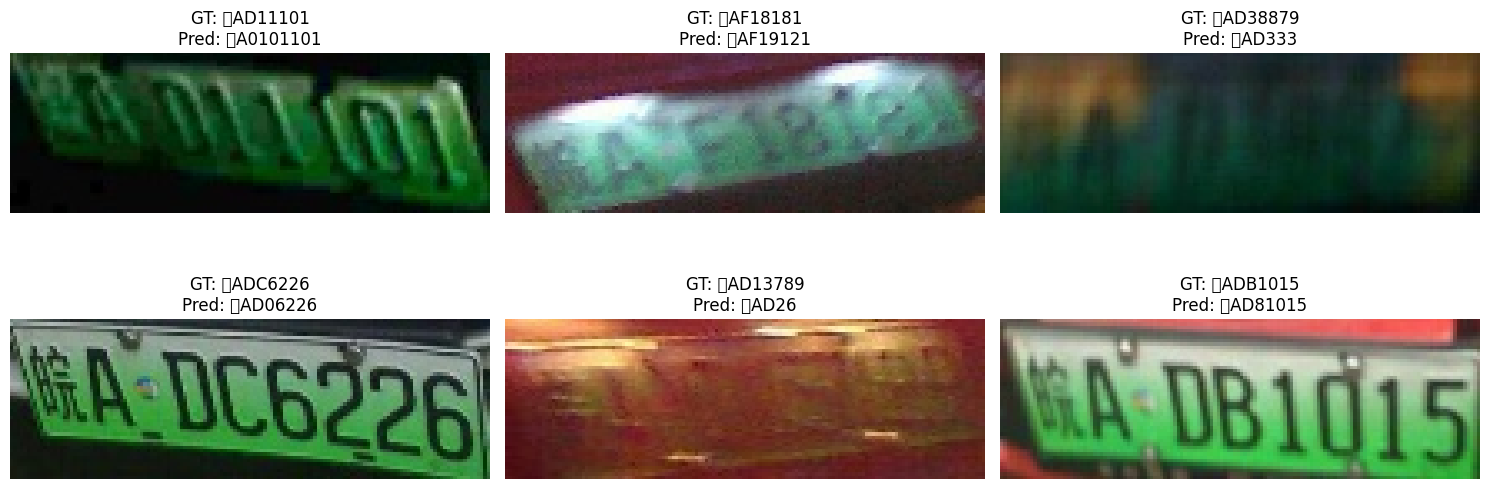

In [ ]:
show_misclassified_images(test_dataset, all_preds, all_targets, num_images=6)